In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)


In [2]:
shed_2024 = pd.read_csv("public2024.csv", low_memory=False)
shed_2024.info()
shed_2024.head()
shed_2024.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12295 entries, 0 to 12294
Columns: 753 entries, CaseID to control
dtypes: float64(24), int64(354), object(375)
memory usage: 70.6+ MB


(12295, 753)

In [3]:
columns = ['SL1', 'SL3', 'SL4A', 'SL4', 'SL6', 'SL7', 'SL8_a', 'SL8_b', 'SL8_c', 'SL8_d', 'SL8_e', 
           'SL10A', 'SL11', 'SL13', 'ppagecat', 'ppinc7', 'ppeducat', 'ppethm', 'ppgender']
subset = shed_2024[columns]
subset.head()

,SL1,SL3,SL4A,SL4,SL6,SL7,SL8_a,SL8_b,SL8_c,SL8_d,SL8_e,SL10A,SL11,SL13,ppagecat,ppinc7,ppeducat,ppethm,ppgender
0,No,NaN,NaN,NaN,NaN,Yes,No,No,No,No,Yes,NaN,Do not have children or grandchildren,NaN,75+,"$25,000 to $49,999",Bachelor's degree or higher,"White, Non-Hispanic",Female
1,No,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,75+,"$100,000 to $149,999",Bachelor's degree or higher,"White, Non-Hispanic",Female
2,No,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,55-64,"$50,000 to $74,999",Bachelor's degree or higher,"White, Non-Hispanic",Male
3,No,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,No,Do not have children or grandchildren,NaN,65-74,"$75,000 to $99,999",High school graduate (high school diploma or t...,"White, Non-Hispanic",Female
4,No,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,No,No,NaN,55-64,"$50,000 to $74,999",Some college or Associate's degree,"White, Non-Hispanic",Female


In [4]:
# Keep only respondents who answered "Yes" to having student loans
# According to SHED: 1 = Yes, 2 = No, 3 = Prefer not to say
borrowers_only_2024 = subset[subset['SL1'] == 'Yes'].copy()

In [5]:
print(f"Original rows: {len(subset)}")
print(f"Borrowers only: {len(borrowers_only_2024)}")

Original rows: 12295
Borrowers only: 1467


In [6]:
borrowers_only_2024.head()

,SL1,SL3,SL4A,SL4,SL6,SL7,SL8_a,SL8_b,SL8_c,SL8_d,SL8_e,SL10A,SL11,SL13,ppagecat,ppinc7,ppeducat,ppethm,ppgender
43,Yes,"$5,000 to $9,999",Yes,$100 to $199,No,NaN,No,No,Yes,No,Yes,Yes,No,NaN,45-54,"$100,000 to $149,999",Bachelor's degree or higher,"White, Non-Hispanic",Male
97,Yes,"$100,000 or above",Yes,"$1,000 or above",Yes,NaN,No,Yes,Yes,No,Yes,Yes,Yes,"$30,000 to $39,999",45-54,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Female
136,Yes,"$50,000 to $74,999",Yes,$300 to $399,No,NaN,No,No,Yes,No,Yes,No,NaN,NaN,25-34,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Female
150,Yes,"$50,000 to $74,999",No,NaN,No,NaN,No,No,No,No,Yes,No,NaN,NaN,25-34,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Male
151,Yes,"$30,000 to $39,999",Yes,$300 to $399,No,NaN,No,No,No,No,Yes,No,Yes,"$30,000 to $39,999",55-64,"$100,000 to $149,999",Bachelor's degree or higher,"White, Non-Hispanic",Female


In [7]:
cols_to_keep = [
    'SL1', 'SL3', 'SL6',       # Loan/payment status
    'ppagecat', 'ppinc7', 'ppeducat',         # Demographics
    'ppethm', 'ppgender'
]
borrowers_clean_2024 = borrowers_only_2024[cols_to_keep]


In [8]:
borrowers_clean_2024 = borrowers_clean_2024.copy()
borrowers_clean_2024["Year"] = "2024"

In [9]:
borrowers_clean_2024 = borrowers_clean_2024.rename(columns={
    "SL1": "Student Loan",
    "SL3": "Amt Owed",
    "SL6": "Delinquent",
    "ppagecat": "Age Category",
    "ppinc7": "Household Income",
    "ppeducat": "Education",
    "ppethm": "Race",
    "ppgender": "Gender"
})

In [10]:
borrowers_clean_2024.head()

,Student Loan,Amt Owed,Delinquent,Age Category,Household Income,Education,Race,Gender,Year
43,Yes,"$5,000 to $9,999",No,45-54,"$100,000 to $149,999",Bachelor's degree or higher,"White, Non-Hispanic",Male,2024
97,Yes,"$100,000 or above",Yes,45-54,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Female,2024
136,Yes,"$50,000 to $74,999",No,25-34,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Female,2024
150,Yes,"$50,000 to $74,999",No,25-34,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Male,2024
151,Yes,"$30,000 to $39,999",No,55-64,"$100,000 to $149,999",Bachelor's degree or higher,"White, Non-Hispanic",Female,2024


In [11]:
borrowers_clean_2024.to_csv("cleaned_borrowers_2024.csv", index=False)

In [12]:
def clean_shed_student_loan_df(df, year):
    # Map income column for each year
    income_column = 'ppinc7' if year >= 2021 else 'ppincimp'
    owed = 'SL3' if year >= 2017 else 'SL3-a' 

    # Define expected columns and optional ones
    columns = ['SL1', 'SL6', income_column, 'ppagecat', 'ppeducat', 'ppethm', 'ppgender']
       
    subset = df[columns].copy()

    # Filter for borrowers (Yes = '1' or 'Yes', depending on encoding)
    subset = subset[subset['SL1'].isin(['1', 'Yes'])].copy()

    # Rename columns to a unified schema
    rename_dict = {
        "SL1": "Student Loan",
        owed: "Amt Owed",
        "SL6": "Delinquent",
        income_column: "Household Income",
        "ppagecat": "Age Category",
        "ppeducat": "Education",
        "ppethm": "Race",
        "ppgender": "Gender"
    }
    subset = subset.rename(columns=rename_dict)

    # Add year column
    subset["Year"] = str(year)

    return subset

In [13]:
shed_2023 = pd.read_csv("public2023.csv", low_memory=False)
shed_2023.info()
shed_2023.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Columns: 595 entries, CaseID to control
dtypes: float64(20), int64(272), object(303)
memory usage: 51.8+ MB


,CaseID,caseid2022,caseid2021,caseid2020,caseid2019,duration,weight,weight_pop,panel_weight,panel_weight_pop,xlaptop,L0_a,L0_b,L0_c,L0_d,L0_e,L0A,L0B_a,L0B_b,L0B_c,L0C,L0E,B2,B3,B6,B7_a,B7_b,X11_none,CG1,CG2,CG3,CG4,CG5_a,CG5_b,CG5_c,CG5_d,CG5_e,CG5_f,CG6,D1A,D4,D48,D3B,D1E,D22_a,D22_b,D22_c,D22_d,D22_e,D22_f,D22_g,D22_h,D22_i,D3A,D28_a,D28_b,D30,D47,D34A,D36A,D36B,D44_f,D44_a,D44_b,D44_c,D44_d,D44_e,D37A,D38_a,D38_b,D38_c,D38_d,D38_f,D39,D45,D5,D49,D41_a,D41_b,D41_c,D41_d,D41_e,D41_f,D41_g,D41_h,D41_i,GH1,GH12,R1_a,R1_b,R1_c,R1_d,R1_e,R1_f,R1_g,R1_h,GH2,R4,R5E,R5B_a,R5B_b,R5B_c,R5B_d,R5C_a,R5C_b,R5C_c,R5C_d,R3,R11,M4,GH3_a,GH3_b,GH3_c,GH3_d,GH3_e,ND0,ND1_a,ND1_b,ND1_c,ND1_d,ND1_e,ND2,ND4_a,ND4_b,ND4_c,BK1,BK2_a,BK2_b,BK2_c,BK2_d,BK2_e,BK2_f,A6,A0,A7_a,A7_b,A7_c,A7_d,A7_e,A7_f,A0B,A1_a,A1_b,A1_c,A8_a,A8_b,A8_c,A8_d,A8_e,A8_f,A2,C2A,C3P,C4A,BNPL1,BNPL3,BNPL3A,BNPL4_a,BNPL4_b,BNPL4_c,BNPL4_d,BNPL4_e,BNPL4_f,BNPL4_g,S16_a,S16_b,S16_c,S18,S21,ED0,D1G,ED0B,ED0D,ED1,ED4,ED9,ED10,ED11_a,ED11_b,ED11_c,ED11_d,SL1,SL3,SL4A,SL4,SL6,SL7,SL8_a,SL8_b,SL8_c,SL8_d,SL8_e,SL10A,SL11,SL13,D1I,K0,K8B,K9_a,K9_b,K9_c,K9_d,K9_e,K9_f,K21_a,K21_b,K21_c,K21_d,K21_e,K21_f,DC4,K5A_a,K5A_b,K5A_c,I0_a,I0_b,I0_c,I0_d,I0_e,I0_f,I40,I41_a,I41_b,I41_c,I41_d,I41_e,I9,I12,I20,I21_a,I21_b,INF4,INF3_a,INF3_b,INF3_c,INF3_d,INF3_e,INF3_f,INF3_g,EF1,EF2,EF3_a,EF3_b,EF3_c,EF3_d,EF3_e,EF3_f,EF3_g,EF3_h,EF5C,EF6C_a,EF6C_b,EF6C_c,EF6C_d,EF7,FD3,FD4,E8_a,E8_b,E8_c,E1_a,E1_b,E1_c,E1_d,E1_e,E2,E2A,E2B,E4_a,E4_b,E4_c,E4_d,E4_e,E4_f,CH2A,DOV_D36_ORDER,DOV_D36_AMOUNT,ppage,ppagecat,ppagect4,ppeduc5,ppeducat,ppemploy,ppethm,ppgender,pphhsize,pphouse4,ppinc7,ppmarit5,ppmsacat,ppreg4,ppreg9,pprent,ppstaten,ppkid017,ppt18ov,ppcm0160,ind1,ppcm1301,UNION100,ppcmdate,Status,pph1date,pph10001,ppfsdate,ppfs0001,ppfs0596,ppfs1482,pphidate,pphi0001,ppracem,pphispan,ppp1date,pppagnid,pppa_lgb,ppp2date,ppp20197,pphi0018,pph12003,pph12004,pph12005,pph12006,pph12007,field_month,field_day,pphhsize5,L0_a_iflag,L0_b_iflag,L0_c_iflag,L0_d_iflag,L0_e_iflag,L0A_iflag,L0B_a_iflag,L0B_b_iflag,L0B_c_iflag,L0C_iflag,L0E_iflag,B2_iflag,B3_iflag,B6_iflag,B7_a_iflag,B7_b_iflag,CG1_iflag,CG2_iflag,CG3_iflag,CG4_iflag,CG5_a_iflag,CG5_b_iflag,CG5_c_iflag,CG5_d_iflag,CG5_e_iflag,CG5_f_iflag,CG6_iflag,D1A_iflag,D4_iflag,D48_iflag,D3B_iflag,D1E_iflag,D22_a_iflag,D22_b_iflag,D22_c_iflag,D22_d_iflag,D22_e_iflag,D22_f_iflag,D22_g_iflag,D22_h_iflag,D22_i_iflag,D3A_iflag,D28_a_iflag,D28_b_iflag,D30_iflag,D47_iflag,D34A_iflag,D36A_iflag,D36B_iflag,D44_f_iflag,D44_a_iflag,D44_b_iflag,D44_c_iflag,D44_d_iflag,D44_e_iflag,D37A_iflag,D38_a_iflag,D38_b_iflag,D38_c_iflag,D38_d_iflag,D38_f_iflag,D39_iflag,D45_iflag,D5_iflag,D49_iflag,D41_a_iflag,D41_b_iflag,D41_c_iflag,D41_d_iflag,D41_e_iflag,D41_f_iflag,D41_g_iflag,D41_h_iflag,D41_i_iflag,GH1_iflag,GH12_iflag,R1_a_iflag,R1_b_iflag,R1_c_iflag,R1_d_iflag,R1_e_iflag,R1_f_iflag,R1_g_iflag,R1_h_iflag,GH2_iflag,R4_iflag,R5E_iflag,R5B_a_iflag,R5B_b_iflag,R5B_c_iflag,R5B_d_iflag,R5C_a_iflag,R5C_b_iflag,R5C_c_iflag,R5C_d_iflag,R3_iflag,R11_iflag,M4_iflag,GH3_a_iflag,GH3_b_iflag,GH3_c_iflag,GH3_d_iflag,GH3_e_iflag,ND0_iflag,ND1_a_iflag,ND1_b_iflag,ND1_c_iflag,ND1_d_iflag,ND1_e_iflag,ND2_iflag,ND4_a_iflag,ND4_b_iflag,ND4_c_iflag,BK1_iflag,BK2_a_iflag,BK2_b_iflag,BK2_c_iflag,BK2_d_iflag,BK2_e_iflag,BK2_f_iflag,A6_iflag,A0_iflag,A7_a_iflag,A7_b_iflag,A7_c_iflag,A7_d_iflag,A7_e_iflag,A7_f_iflag,A0B_iflag,A1_a_iflag,A1_b_iflag,A1_c_iflag,A8_a_iflag,A8_b_iflag,A8_c_iflag,A8_d_iflag,A8_e_iflag,A8_f_iflag,A2_iflag,C2A_iflag,C3P_iflag,C4A_iflag,BNPL1_iflag,BNPL3_iflag,BNPL3A_iflag,BNPL4_a_iflag,BNPL4_b_iflag,BNPL4_c_iflag,BNPL4_d_iflag,BNPL4_e_iflag,BNPL4_f_iflag,BNPL4_g_iflag,S16_a_iflag,S16_b_iflag,S16_c_iflag,S18_iflag,S21_iflag,ED0_iflag,D1G_iflag,ED0B_iflag,ED0D_iflag,ED1_iflag,ED9_iflag,ED10_iflag,ED11_a_iflag,ED11_b_iflag,ED11_c_iflag,ED11_d_iflag,SL1_iflag,SL3_iflag,SL4A_iflag,SL4_iflag,SL6_iflag,SL7_iflag,SL8_a_iflag,SL8_b_iflag,SL8_c_iflag,SL8_d_iflag,SL8_e_iflag,SL10A_iflag,SL11_i

In [14]:
borrowers_clean_2023 = clean_shed_student_loan_df(shed_2023, 2023)

In [15]:
borrowers_clean_2023.head()

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
15,Yes,No,"$150,000 or more",45-54,Bachelor's degree or higher,"White, Non-Hispanic",Female,2023
24,Yes,No,"$150,000 or more",55-64,Bachelor's degree or higher,"Other, Non-Hispanic",Male,2023
31,Yes,No,"$150,000 or more",45-54,Bachelor's degree or higher,Hispanic,Male,2023
58,Yes,No,"$100,000 to $149,999",35-44,Bachelor's degree or higher,"White, Non-Hispanic",Male,2023
91,Yes,No,"$25,000 to $49,999",55-64,Some college or Associate's degree,"White, Non-Hispanic",Female,2023


In [16]:
borrowers_clean_2023.to_csv("cleaned_borrowers_2023.csv", index=False)

In [17]:
encoding = 'cp1252'  # Define the encoding first

shed_2022 = pd.read_csv("public2022.csv", encoding=encoding, low_memory=False)
shed_2021 = pd.read_csv("public2021.csv", encoding=encoding, low_memory=False)
shed_2020 = pd.read_csv("public2020.csv", encoding=encoding, low_memory=False)
shed_2019 = pd.read_csv("public2019.csv", encoding=encoding, low_memory=False)
shed_2018 = pd.read_csv("public2018.csv", encoding=encoding, low_memory=False)
shed_2017 = pd.read_csv("public2017.csv", encoding=encoding, low_memory=False)
shed_2016 = pd.read_csv("public2016.csv", encoding=encoding, low_memory=False)
shed_2015 = pd.read_csv("public2015.csv", encoding=encoding, low_memory=False)

In [18]:
borrowers_clean_2022 = clean_shed_student_loan_df(shed_2022, 2022)
borrowers_clean_2022.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
7,Yes,Yes,"$25,000 to $49,999",55-64,Some college or Associate's degree,"Black, Non-Hispanic",Female,2022
9,Yes,No,"$10,000 to $24,999",65-74,Bachelor's degree or higher,"White, Non-Hispanic",Female,2022


In [19]:
borrowers_clean_2021 = clean_shed_student_loan_df(shed_2021, 2021)
borrowers_clean_2021.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
31,Yes,No,"$50,000 to $74,999",45-54,Some college or Associate's degree,"2+ Races, Non-Hispanic",Male,2021
56,Yes,No,"$150,000 or more",45-54,Bachelor's degree or higher,"White, Non-Hispanic",Male,2021


In [20]:
borrowers_clean_2020 = clean_shed_student_loan_df(shed_2020, 2020)
borrowers_clean_2020.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
28,Yes,Yes,"$200,000 to $249,999",55-64,Bachelor's degree or higher,"Other, Non-Hispanic",Male,2020
31,Yes,No,"$35,000 to $39,999",45-54,Some college,"2+ Races, Non-Hispanic",Male,2020


In [21]:
borrowers_clean_2019 = clean_shed_student_loan_df(shed_2019, 2019)
borrowers_clean_2019.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
20,Yes,No,"$150,000 to $174,999",35-44,Bachelor's degree or higher,"White, Non-Hispanic",Female,2019
44,Yes,No,"$15,000 to $19,999",45-54,Some college,"2+ Races, Non-Hispanic",Male,2019


In [22]:
borrowers_clean_2018 = clean_shed_student_loan_df(shed_2018, 2018)
borrowers_clean_2018.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
26,Yes,No,"$30,000 to $34,999",25-34,Bachelor's degree or higher,"White, Non-Hispanic",Male,2018
29,Yes,No,"$150,000 to $174,999",45-54,Bachelor's degree or higher,"White, Non-Hispanic",Male,2018


In [23]:
borrowers_clean_2017 = clean_shed_student_loan_df(shed_2017, 2017)
borrowers_clean_2017.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
4,Yes,No,"$100,000 to $124,999",25-34,Bachelor's degree or higher,"White, Non-Hispanic",Male,2017
8,Yes,No,"$250,000 or more",25-34,Bachelor's degree or higher,"White, Non-Hispanic",Female,2017


In [24]:
borrowers_clean_2016 = clean_shed_student_loan_df(shed_2016, 2016)
borrowers_clean_2016.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
5,Yes,No,"$100,000 to $124,999",25-34,Bachelor's degree or higher,"White, Non-Hispanic",Male,2016
9,Yes,No,"$250,000 or more",25-34,Bachelor's degree or higher,"White, Non-Hispanic",Female,2016


In [25]:
borrowers_clean_2015 = clean_shed_student_loan_df(shed_2015, 2015)
borrowers_clean_2015.head(2)

,Student Loan,Delinquent,Household Income,Age Category,Education,Race,Gender,Year
4,Yes,No,"Less than $5,000",35-44,Some college,Hispanic,Female,2015
7,Yes,No,"$100,000 to $124,999",25-34,Bachelor's degree or higher,"White, Non-Hispanic",Male,2015


In [26]:
all_borrowers = pd.concat([
    borrowers_clean_2024,
    borrowers_clean_2023,
    borrowers_clean_2022,
    borrowers_clean_2021,
    borrowers_clean_2020,
    borrowers_clean_2019,
    borrowers_clean_2018,
    borrowers_clean_2017,
    borrowers_clean_2016,
    borrowers_clean_2015
], ignore_index=True)

In [27]:
all_borrowers.to_csv("SHED_cleaned_all_borrowers.csv", index=False)

In [28]:
all_borrowers["Education"] = all_borrowers["Education"].replace({
    "Some college or Associate's degree": "Some college",
    "High school graduate (high school diploma or the equivalent GED)": "High school",
    "Bachelor’s degree or higher": "Bachelor's degree or higher",  # normalize curly quotes
    "No high school diploma or GED": "Less than high school"
})

In [29]:
edu_order = [
    "Less than high school",
    "High school",
    "Some college",
    "Bachelor's degree or higher"
]

# Set ordered category
all_borrowers["Education"] = pd.Categorical(
    all_borrowers["Education"], 
    categories=edu_order, 
    ordered=True
)

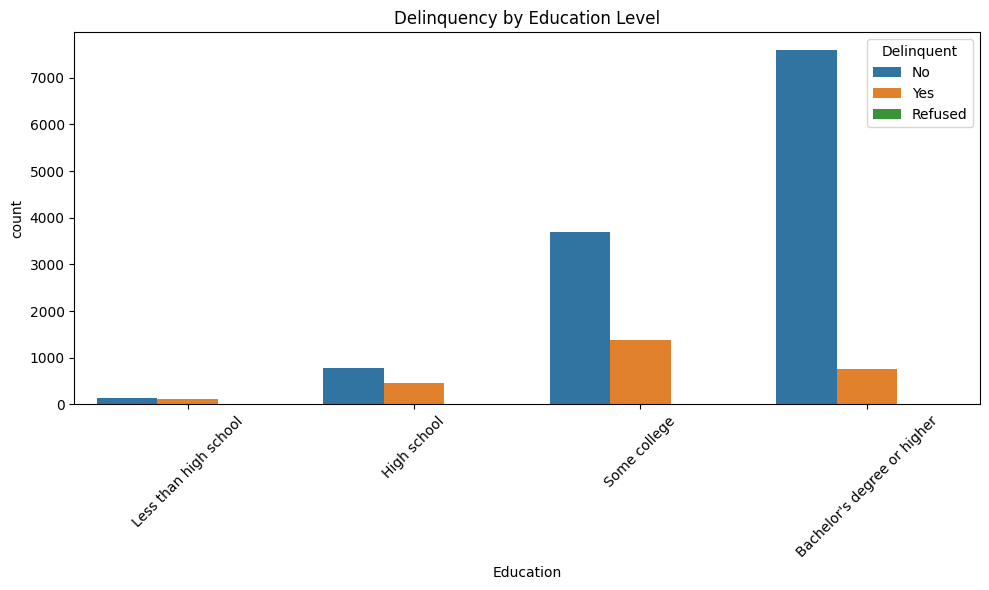

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(data=all_borrowers, x='Education', hue='Delinquent', order=edu_order)
plt.title("Delinquency by Education Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
def plot_percent_delinquent(df, group_col, title):
    # Filter to valid Delinquent responses
    df_filtered = df[df["Delinquent"].isin(["Yes", "No"])].copy()
    
    # Group by demographic and delinquency status
    grouped = df_filtered.groupby([group_col, "Delinquent"]).size().unstack(fill_value=0)
    
    # Calculate percent delinquent
    grouped["Percent Delinquent"] = grouped["Yes"] / (grouped["Yes"] + grouped["No"]) * 100
    
    # Sort by percent (optional)
    grouped = grouped.sort_values("Percent Delinquent", ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=grouped.index, y="Percent Delinquent", data=grouped)
    plt.title(f"{title} – Percent Delinquent")
    plt.ylabel("Percent")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\heath\AppData\Local\Temp\ipykernel_9908\1557511370.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filtered.groupby([group_col, "Delinquent"]).size().unstack(fill_value=0)


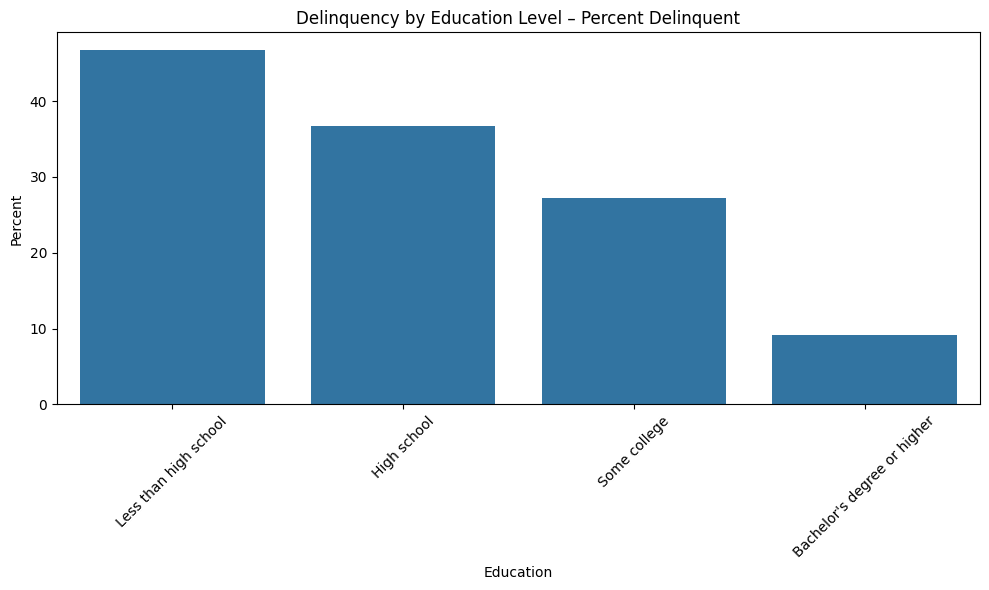

In [32]:
plot_percent_delinquent(all_borrowers, "Education", "Delinquency by Education Level")

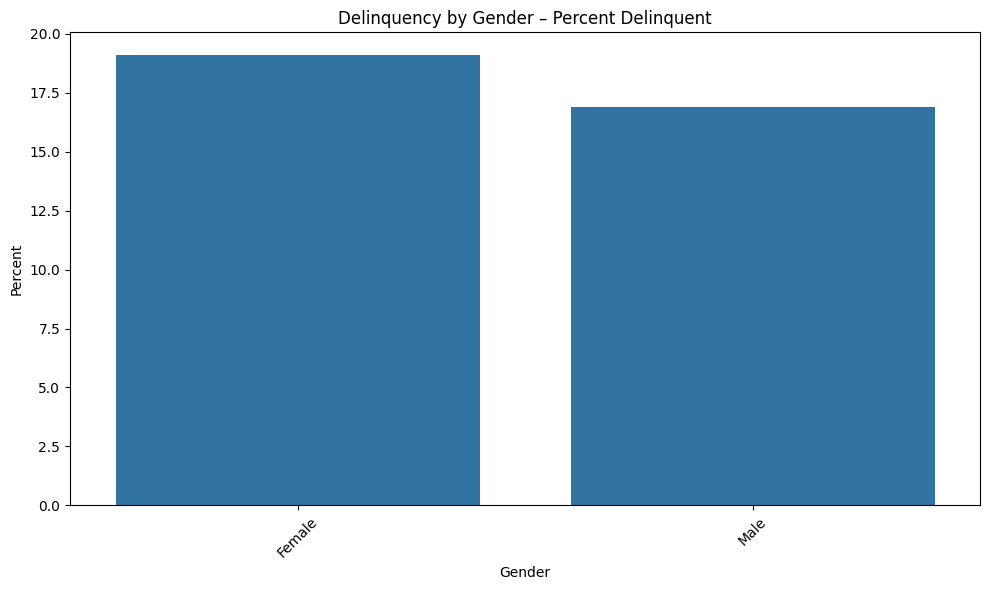

In [33]:
plot_percent_delinquent(all_borrowers, "Gender", "Delinquency by Gender")

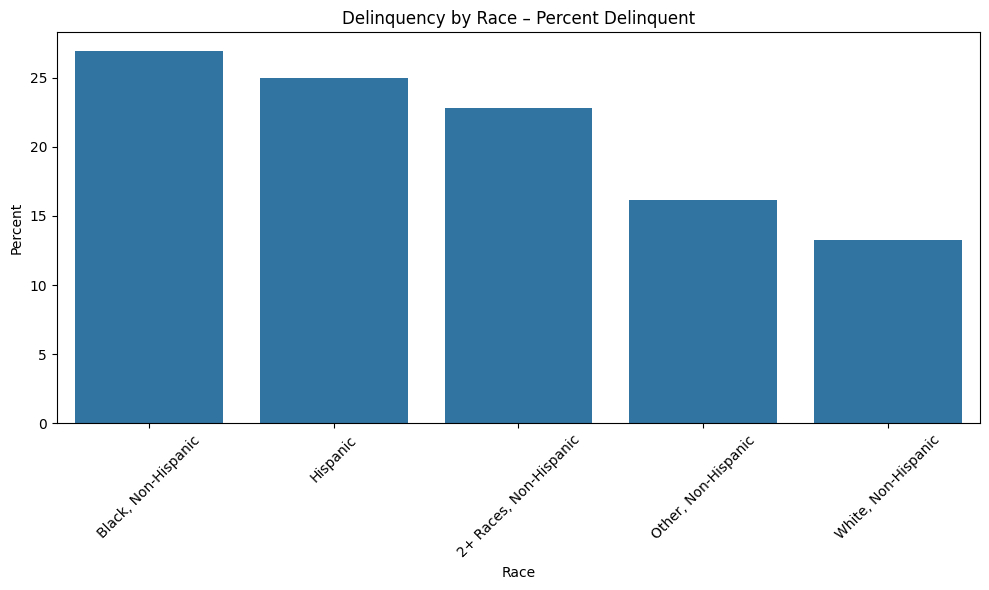

In [34]:
plot_percent_delinquent(all_borrowers, "Race", "Delinquency by Race")

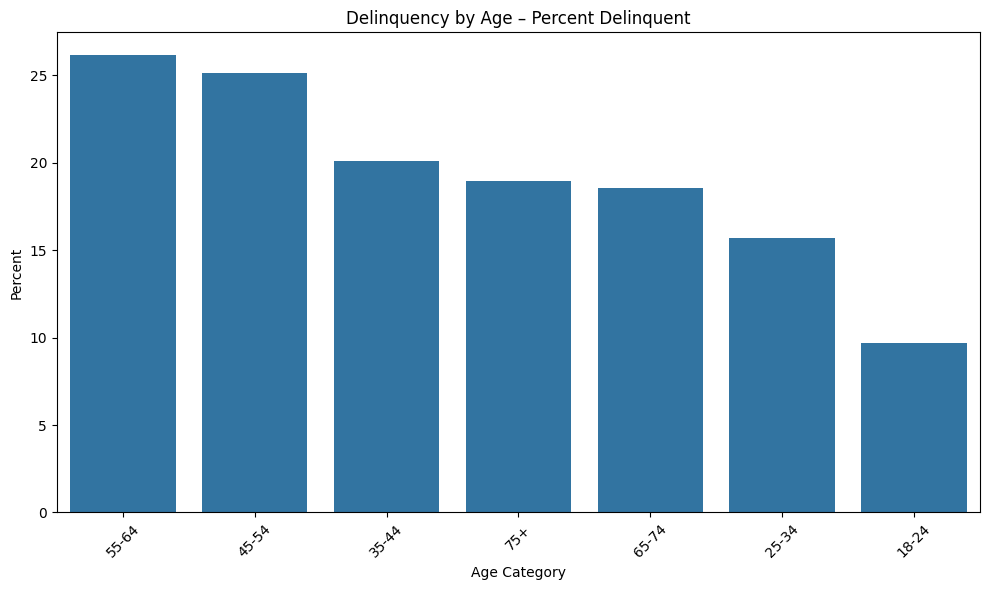

In [35]:
plot_percent_delinquent(all_borrowers, "Age Category", "Delinquency by Age")

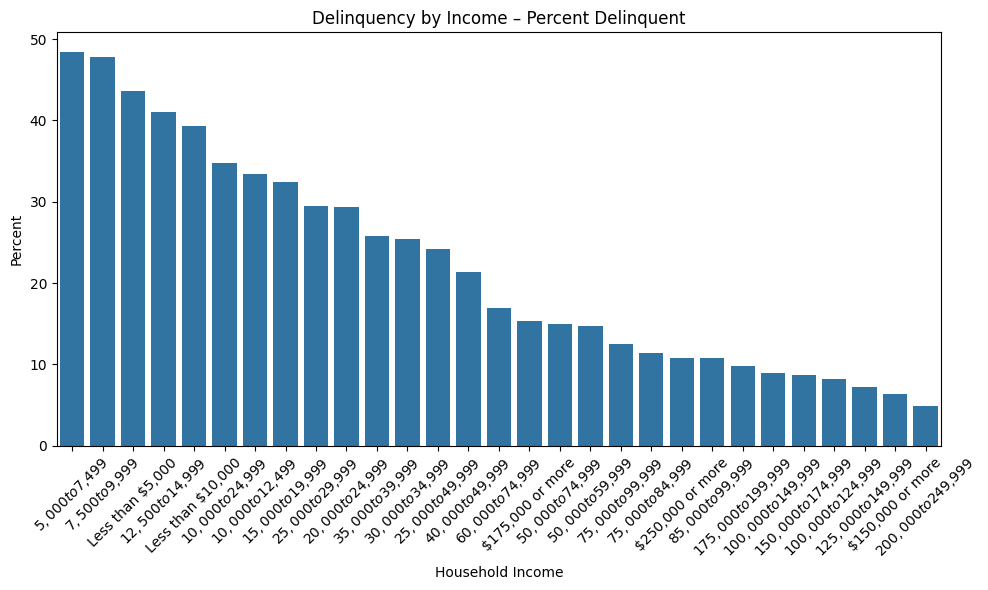

In [36]:
plot_percent_delinquent(all_borrowers, "Household Income", "Delinquency by Income")